Getting into the right folder and enviroment


In [1]:
from google.colab import drive
drive.mount('/content/drive')
FOLDER_NAME = 'Kaggle-ML/Neuromatch_Project'
FOLDER_PATH = f'drive/My Drive/{FOLDER_NAME}/'
%cd "{FOLDER_PATH}"

Mounted at /content/drive
/content/drive/My Drive/Kaggle-ML/Neuromatch_Project


In [2]:
DATASET_ROOT = 'dataset'
TRAIN_FOLDER = f'{DATASET_ROOT}/Training'
TEST_FOLDER = f'{DATASET_ROOT}/Testing'
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = 224
TRAIN_BATCH_SIZE= 64
TRAIN_NUM_WORKERS= 1
VAL_BATCH_SIZE= 4
VAL_NUM_WORKERS= 1
TEST_BATCH_SIZE= 4
TEST_NUM_WORKERS= 1
TRAIN_SIZE= 2476
VALIDATION_SIZE = 394
SAVING_PATH="brain_tumor_resnet50.pt"

Installing dependencies

In [3]:
import torch,gc
import pathlib
import cv2 
import matplotlib.pyplot as plt 
import imutils
import time


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms, models, utils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import time

In [4]:
# Setting the right device
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
device

device(type='cuda', index=0)

In [5]:
# Preprocessing: Cropping brain contour

def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
           
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()

    return new_image

In [6]:
from numpy import dtype
# Defining custom dataset with augmentations
class CustomDataset(ImageFolder):
  def __init__(self, root, transforms):
    super(CustomDataset, self).__init__(root=root, transform=transforms)
    self.transform = transforms

  def __getitem__(self, index):
    image_path, target = self.samples[index]

    cv2_image = cv2.imread(image_path)
    cv2_image = crop_brain_contour(cv2_image, plot=False)

    # resize image
    cv2_image = cv2.resize(cv2_image, dsize=(IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_CUBIC)
    # normalize values
    cv2_image= cv2_image/255

    sample = transforms.ToTensor()(cv2_image).float()

    if self.transform:
       sample = self.transform(sample)
    
    return sample, target

In [7]:
# To do Split here!!!!


# Data Augmentation using transforms
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize(IMAGE_SIZE),
                                        transforms.RandomCrop(IMAGE_SIZE),                           
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.RandomRotation(degrees=(30, 70)),
                                        transforms.ToTensor(),
                                     ])


data_path = pathlib.Path('.')/'afhq'  # Using pathlib to be compatible with all OS's
dataset = CustomDataset(TRAIN_FOLDER, transforms=train_transforms)

In [8]:
test_ds = CustomDataset(TRAIN_FOLDER, transforms=None)

In [9]:
# Create random split of training vs validation
validation_ds, train_ds = torch.utils.data.random_split(dataset, [VALIDATION_SIZE,TRAIN_SIZE])

In [10]:
# Don't do transforms on validation DS
validation_ds.dataset.transform = None

In [11]:
# Train Dataloader
train_dataloader = DataLoader(
    train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
    num_workers=TRAIN_NUM_WORKERS, pin_memory=True
)

# Validation Dataloader
validation_dataloader = DataLoader(
    validation_ds, batch_size=VAL_BATCH_SIZE, shuffle=True,
    num_workers=VAL_NUM_WORKERS, pin_memory=True
)

# Test Dataloader
test_dataloader = DataLoader(
    test_ds, batch_size=TEST_BATCH_SIZE, shuffle=True,
    num_workers=TEST_NUM_WORKERS, pin_memory=True
)

In [12]:
#Dataloaders output a 4 dimensional tensor - [batch, channel, height, width]
batch = next(iter(train_dataloader))
train_images_batch, train_labels_batch = batch
print(f"Feature batch shape: {train_images_batch.size()}")
print(f"Labels batch shape: {train_labels_batch.size()}")

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


In [13]:
batch = next(iter(train_dataloader))

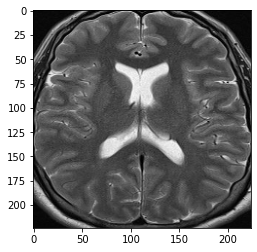

In [14]:
image = train_images_batch[0]
image = image.permute(1,2,0)
plt.imshow(image)

In [15]:
classes_training= dataset.class_to_idx
classes_training

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [16]:
classes = {}
for key,value in classes_training.items():
  classes[value] = key
classes

{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

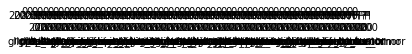

In [17]:
# Show a batch 
def show_batch(batch_images, batch_labels):
  batch,_,_,_ = batch_images.shape
  for i in range(batch):
    # plt subplot subplot(nrows, ncols, index, **kwargs)
    axes = plt.subplot(1,TRAIN_BATCH_SIZE,i+1)
    class_idx = batch_labels[i].item()
    label = classes[class_idx]
    axes.set(xlabel=label)
    plt.imshow(batch_images[i].permute(1,2,0))

  plt.show()

show_batch(train_images_batch, train_labels_batch)

# Implementing RESNET 
Credits to: https://www.kaggle.com/code/jarvisgroot/brain-tumor-classification-in-pytorch/notebook

In [18]:
# instantiate transfer learning model
resnet_model = models.resnet50(pretrained=True)

# print the trasnfer learning NN model's architecture
resnet_model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
# instantiate transfer learning model
resnet_model = models.resnet50(pretrained=True)

# set all paramters as trainable
for param in resnet_model.parameters():
    param.requires_grad = True

# get input of fc layer
n_inputs = resnet_model.fc.in_features
n_classes = 4

# redefine fc layer / top layer/ head for our classification problem
resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 64),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(64, 64),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(64, n_classes),
                                nn.LogSoftmax(dim=1))
                                #nn.Softmax())
                                #nn.LogSigmoid())

# set all paramters of the model as trainable
for name, child in resnet_model.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

# set model to run on GPU or CPU absed on availibility
resnet_model.to(device)

# print the trasnfer learning NN model's architecture
resnet_model


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
torch.cuda.empty_cache()

In [21]:
# loss function
# if GPU is available set loss function to use GPU
criterion = nn.NLLLoss().to(device)

# optimizer
optimizer = torch.optim.SGD(resnet_model.parameters(), momentum=0.9, lr=1e-3)

# number of training iterations
epochs = 20

# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [22]:
# Load model
#resnet_model.load_state_dict(torch.load(SAVING_PATH))

FileNotFoundError: ignored

In [ ]:
# Save model
#torch.save(resnet_model.state_dict(), SAVING_PATH)

In [23]:
# Get a batch of training data
inputs, labels = next(iter(train_dataloader))
inputs = inputs.to(device)
labels= labels.to(device)
outputs = resnet_model(inputs)
outputs
#4x1

tensor([[-1.8369, -1.4570, -1.4060, -1.0143],
        [-1.6193, -1.7233, -1.4355, -0.9532],
        [-1.5272, -1.7325, -1.6601, -0.8773],
        [-1.3877, -1.3869, -1.1660, -1.6665],
        [-1.5300, -1.6824, -1.3159, -1.1108],
        [-1.7239, -1.2444, -1.4162, -1.2348],
        [-1.2597, -1.7022, -1.4578, -1.1999],
        [-1.5307, -1.7676, -1.0091, -1.3929],
        [-1.2005, -1.8749, -1.4812, -1.1450],
        [-1.5525, -1.6655, -1.3601, -1.0713],
        [-1.5872, -1.8404, -1.4759, -0.8960],
        [-1.9471, -1.7905, -1.4637, -0.7786],
        [-1.6637, -1.7019, -0.9358, -1.4441],
        [-1.5238, -1.8179, -1.4080, -0.9805],
        [-1.3598, -1.6647, -1.4358, -1.1517],
        [-1.3910, -2.1780, -1.0719, -1.2190],
        [-1.2079, -2.3053, -1.5699, -0.9330],
        [-1.9840, -1.5567, -1.3386, -0.9430],
        [-1.3643, -2.0094, -1.0407, -1.3581],
        [-1.8385, -1.4791, -1.4778, -0.9546],
        [-1.1997, -2.2521, -1.6221, -0.9262],
        [-1.8093, -1.4865, -1.0513

In [27]:
# set training start time
start_time = time.time()
results = []
print('TRAINING STARTED')

# start training
for epoch in range(epochs):
    
    # set epoch's starting time
    e_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))

    # setting model to training mode
    resnet_model.train() 

    # loss and accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
    nBatches=0
    
    # train in batches
    for batch, (inputs, labels) in enumerate(train_dataloader):
        nBatches+=1
        # set label as cuda if device is cuda
        inputs = inputs.to(device)
        labels= labels.to(device)

        #Cleaning existing gradients
        optimizer.zero_grad()
          
        # forward pass image sample
        outputs = resnet_model(inputs)
        torch.cuda.empty_cache()
        
        # calculate loss
        loss = criterion(outputs, labels)

        # back propagate with loss
        loss.backward()
        
        # perform optimizer step
        optimizer.step()

        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() #* inputs.size(0)

        # Compute accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        # Convert correct counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
	      
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() 

        #print("Batch number: {:03d}".format(batch, loss.item(), acc.item()))
          
      
    # set epoch's end time
    e_end = time.time()
    # print training metrics
    
    print(f'Epoch {(epoch+1)},  Duration: {((e_end-e_start)/60):.2f} minutes , Training Loss {train_loss/nBatches}, Accuracy {train_acc/nBatches} ') 

    results.append({"epoch": epoch+1, "duration": (e_end-e_start)/60, "loss":train_loss/nBatches, "acurravg_train_loss = train_loss/train_data_size
25
	        avg_train_acc = train_acc/float(train_data_size)acy": train_acc/nBatches })

TRAINING STARTED
Epoch: 1/20
Epoch 1,  Duration: 2.22 minutes , Training Loss 0.8443839809833429, Accuracy 0.7199519230769231 
Epoch: 2/20
Epoch 2,  Duration: 0.45 minutes , Training Loss 0.5143910623513736, Accuracy 0.8352272724493955 
Epoch: 3/20
Epoch 3,  Duration: 0.45 minutes , Training Loss 0.33413779200651705, Accuracy 0.9002768061099908 
Epoch: 4/20
Epoch 4,  Duration: 0.46 minutes , Training Loss 0.21396814802518258, Accuracy 0.9457313525371063 
Epoch: 5/20
Epoch 5,  Duration: 0.45 minutes , Training Loss 0.1288236643259342, Accuracy 0.9709717371524909 
Epoch: 6/20
Epoch 6,  Duration: 0.46 minutes , Training Loss 0.0798721282910078, Accuracy 0.9883814102564102 
Epoch: 7/20
Epoch 7,  Duration: 0.45 minutes , Training Loss 0.053681317095955215, Accuracy 0.9942089166396704 
Epoch: 8/20


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0bbcf22c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0bbcf22c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 8,  Duration: 0.46 minutes , Training Loss 0.03504782850639178, Accuracy 0.9975961538461539 
Epoch: 9/20


KeyboardInterrupt: ignored

In [28]:
# Save model
torch.save(resnet_model.state_dict(), SAVING_PATH)

In [29]:
# resnet_model.eval()
results

[{'acurracy': 0.7199519230769231,
  'duration': 2.2178258101145425,
  'epoch': 1,
  'loss': 0.8443839809833429},
 {'acurracy': 0.8352272724493955,
  'duration': 0.4543046514193217,
  'epoch': 2,
  'loss': 0.5143910623513736},
 {'acurracy': 0.9002768061099908,
  'duration': 0.4496458649635315,
  'epoch': 3,
  'loss': 0.33413779200651705},
 {'acurracy': 0.9457313525371063,
  'duration': 0.4559894720713297,
  'epoch': 4,
  'loss': 0.21396814802518258},
 {'acurracy': 0.9709717371524909,
  'duration': 0.4529697378476461,
  'epoch': 5,
  'loss': 0.1288236643259342},
 {'acurracy': 0.9883814102564102,
  'duration': 0.45522510608037314,
  'epoch': 6,
  'loss': 0.0798721282910078},
 {'acurracy': 0.9942089166396704,
  'duration': 0.45422760645548504,
  'epoch': 7,
  'loss': 0.053681317095955215},
 {'acurracy': 0.9975961538461539,
  'duration': 0.46219257911046346,
  'epoch': 8,
  'loss': 0.03504782850639178}]

In [ ]:
valid_loss = 0.0
valid_acc = 0.0
nBatches=0
valid_results = []

# Validation loop
with torch.no_grad():
  # Set to evaluation mode
  resnet_model.eval()

  for j, (inputs, labels) in enumerate(validation_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    nBatches+=1

    # Forward pass 
    outputs = resnet_model(inputs)

    # Compute Loss
    loss = criterion(outputs, labels)

    # Compute the total loss for the batch
    valid_loss += loss.item()

    # Calculate validation accuracy
    ret, predictions = torch.max(outputs.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
    valid_acc += acc.item()

  print(f'Duration: {((e_end-e_start)/60):.2f} minutes , Training Loss {valid_loss/nBatches}, Accuracy {valid_acc/nBatches} ') 

  valid_results.append({"duration": (e_end-e_start)/60, "loss":valid_loss/nBatches, "acurracy": valid_acc/nBatches })

In [35]:
valid_results

[{'acurracy': 0.9267676767676768,
  'duration': -1.4058748881022136e-05,
  'epoch': 9,
  'loss': 0.1813682295744204}]

In [37]:
test_loss = 0.0
test_acc = 0.0
nBatches=0
test_results = []

# Validation loop
with torch.no_grad():
  # Set to evaluation mode
  resnet_model.eval()

  for j, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    nBatches+=1

    # Forward pass 
    outputs = resnet_model(inputs)

    # Compute Loss
    loss = criterion(outputs, labels)

    # Compute the total loss for the batch
    test_loss += loss.item()

    # Calculate validation accuracy
    ret, predictions = torch.max(outputs.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
    test_acc += acc.item()

  print(f'Duration: {((e_end-e_start)/60):.2f} minutes , Training Loss {test_loss/nBatches}, Accuracy {test_acc/nBatches} ') 

  test_results.append({"duration": (e_end-e_start)/60, "loss":test_loss/nBatches, "acurracy": test_acc/nBatches })


Duration: -0.00 minutes , Training Loss 0.0327504176389806, Accuracy 0.9892061281337048 


In [38]:
test_results

[{'acurracy': 0.9892061281337048,
  'duration': -1.4058748881022136e-05,
  'loss': 0.0327504176389806}]